In [1]:
import pandas as pd
import numpy as np
from docplex.mp.model import Model

# Minimização de VaR

Páginas 18 e 19 dos slides de Downside Risk

In [2]:
# Obtendo retorno dos ativos a partir dos preços
df_prices = pd.read_csv('../data/IBOV.csv', parse_dates=['Date'], index_col='Date')
df_returns = df_prices.loc['2019':].pct_change().dropna().drop('IBOV', axis=1) # Remove índice bovespa
df_returns.head()

,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.001138,0.010801,0.001101,0.010151,0.043413,0.004174,0.010940,0.006354,0.020850,0.010115,...,0.033004,0.011641,-0.026868,-0.042693,0.002741,-0.006029,0.023256,-0.022082,-0.040788,0.022753
2019-01-04,0.005682,0.013828,-0.003299,-0.033185,-0.036179,0.000000,-0.010020,-0.018942,-0.021965,-0.007942,...,-0.000933,0.046030,-0.045008,0.016689,0.039636,0.005199,0.027893,0.059140,0.064935,0.011680
2019-01-07,-0.000226,-0.004340,-0.026207,-0.044235,-0.005255,-0.006563,-0.014575,-0.006436,0.008668,0.011834,...,0.016573,0.002200,0.016238,-0.045748,-0.011394,0.032759,-0.022111,0.002030,-0.005311,-0.015943
2019-01-08,0.003956,-0.019925,-0.016431,0.046282,0.002642,-0.011231,-0.014790,0.001619,0.010937,0.006192,...,-0.007348,0.003293,0.022993,0.009870,-0.006206,0.037563,-0.040082,-0.028369,0.009690,-0.007821
2019-01-09,0.016774,0.013977,0.012385,0.066232,0.004893,-0.002895,-0.031693,0.016168,0.020866,0.017094,...,0.013879,0.007659,0.009524,0.059760,0.000000,0.012068,0.038544,0.033368,0.024285,0.010698


In [3]:
# utilizei um período menor pois o modelo leva um tempo para resolver
in_sample = df_returns.loc['2019-10':'2019-12']
out_of_sample = df_returns.loc['2020']

## Constantes

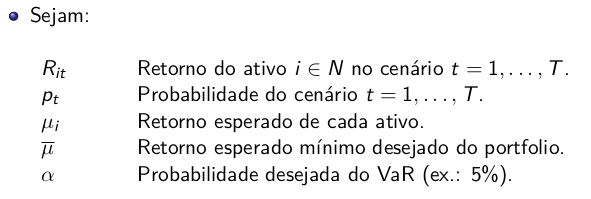

In [4]:
N = in_sample.shape[1] # Quantidade de ativos
T = in_sample.shape[0] # Quantidade de cenários
R = in_sample # A opção de R ser um DataFrame e não uma matriz é para preservar o nome das colunas
p = [1/T for i in range(T)] # Cenários são equiprovávies
u = [sum(p * R[ativo]) for ativo in R.columns]
u_hat = 0.10
alpha = 0.10
M = 999_999
epsilon = 1e-08

In [5]:
print(f"Quantidade de cenários: {T}")
print(f"Quantidade de ativos: {N}")
print(f"Quantidade de probabilidades: {len(p)}")
print(f"Quantidade de retornos esperados: {len(u)}")

Quantidade de cenários: 61
Quantidade de ativos: 71
Quantidade de probabilidades: 61
Quantidade de retornos esperados: 71


## Variáveis de decisão

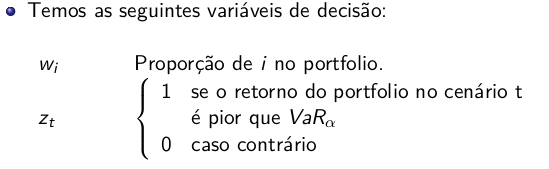

In [6]:
from docplex.mp.model import Model

model = Model()
w = model.continuous_var_list(keys=R.columns, name='w', ub=1, lb=0)
z = model.binary_var_list(keys=R.index, name='z')
Y = model.continuous_var(name='Y')

# Neste modelo de otimização é possível dar nomes aos índices das variáveis de decisão,
# por esse motivo as keys (chaves) aqui são os nomes das colunas (ativos) nos pesos 'w' e as datas no 'z'

## Função objetivo e restrições

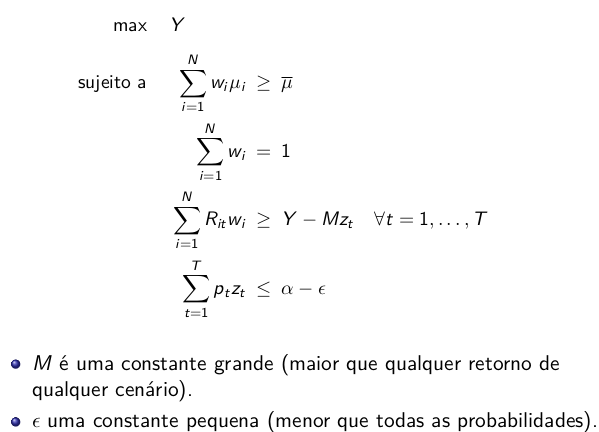

In [7]:
# Restrição do retorno médio do portfólio
# model.add_constraint(model.sum([w[i] * u[i] for i in range(N)]) >= u_hat) # Desativada pois não encontra solução
                                                                            # para os dados de entrada

# Restrição do somátorio dos pesos
model.add_constraint(model.sum(w) == 1)

# Restrição do retorno do cenário menor que Y - Mzt
for t in range(T):
    model.add_constraint(
        model.sum([R.values[t][i] * w[i] for i in range(N)]) >= (Y - (M*z[t]))
    )
    
# Restrição do número de cenários que podem ter CVaR menor que alpha
model.add_constraint(model.sum([(p[t] * z[t]) for t in range(T)]) <= (alpha - epsilon))

# Função objetivo
model.maximize(Y)

# Resolvendo modelo
model.solve()
model.get_solve_details()

docplex.mp.SolveDetails(time=0.349367,status='integer optimal, tolerance')

## Conferindo solução

In [8]:
# Pandas series
solution = pd.Series(
    data=[w[i].solution_value for i in range(N)],
    index=[w[i].get_name() for i in range(N)]
)
solution[(solution > 0) | (solution < 0)]

w_BBSE3     0.001709
w_BRML3     0.100364
w_BRAP4     0.017068
w_BPAC11    0.095106
w_CSAN3     0.005138
w_ELET3     0.026731
w_EMBR3     0.027949
w_ENBR3     0.015391
w_YDUQ3     0.036498
w_FLRY3     0.123112
w_GGBR4     0.050080
w_GNDI3     0.006109
w_BEEF3     0.027693
w_MRVE3     0.008582
w_BRDT3     0.077341
w_SBSP3     0.006548
w_SUZB3     0.022074
w_TAEE11    0.248594
w_TIMP3     0.084634
w_WEGE3     0.019281
dtype: float64

In [9]:
# DataFrame
weights = pd.DataFrame()
weights['ativo'] = R.columns
weights['peso'] = [w[i].solution_value for i in range(N)]
weights[weights['peso'] > 0]

,ativo,peso
6,BBSE3,0.001709
7,BRML3,0.100364
10,BRAP4,0.017068
13,BPAC11,0.095106
20,CSAN3,0.005138
25,ELET3,0.026731
27,EMBR3,0.027949
28,ENBR3,0.015391
31,YDUQ3,0.036498
32,FLRY3,0.123112


## Verificando retornos e VaR

In [10]:
ativos = weights[weights['peso'] > 0]['ativo'].values
pesos = weights[weights['peso'] > 0]['peso'].values
rpt = in_sample[ativos].apply(lambda row: row * pesos, axis=1)
rp = rpt.mean(axis=1)

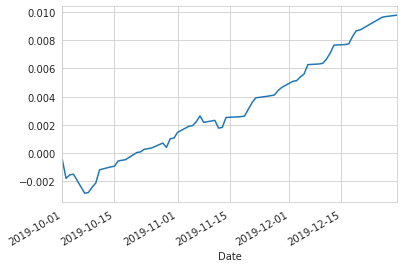

In [16]:
import matplotlib.pyplot as plt
rp.add(1).cumprod().sub(1).plot()

In [17]:
# VaR do portfólio alocado
sorted(rp)[int(alpha * len(rp))]

4.581974393532545e-05

In [18]:
# VaR do portfolio definido pelo mercado
rm = in_sample.mean(axis=1)
rm.quantile(alpha)

-0.007094402519643125

In [19]:
ibov = pd.read_csv('../data/IBOV.csv', parse_dates=['Date'], index_col='Date')['IBOV'].pct_change()
ibov = ibov.loc[in_sample.index]
ibov.quantile(alpha)

-0.007625586974717602

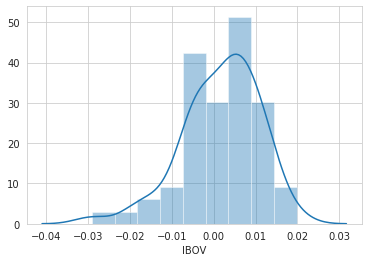

In [20]:
import seaborn as sns; sns.set_style('whitegrid')
sns.distplot(ibov)